In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap 

import pandas as pd
import nibabel as nib
import nilearn.plotting

import mne

In [2]:
sub_ses = [['SD010','01'],
           ['SD011','01'],
           ['SD013','01'],
           ['SD015','01'],
           ['SD017','01'],
           ['SD018','01'],
           ['SD019','01'],
           ['SD021','01'],
           ['SD022','01']]

In [3]:
bands = ['th','d','a','b','g','hg']

In [4]:
with open("Figure1-S10/mni_electrode_coordinates.pkl", 'rb') as f:
    elec_coord_dic = pickle.load(f)

In [5]:
def set_electrode_values(data, ch_list, elec_coords, value=1, offset=0.5):
    mid = data.shape[0] // 2
    for ch in ch_list:
        if ch in elec_coords.keys():
            [x, y, z] = elec_coords[ch]
            data[mid+int(x)][mid+int(y)][mid+int(z)] = np.maximum(value, data[mid+int(x)][mid+int(y)][mid+int(z)])
            data[mid+int(x)+1][mid+int(y)][mid+int(z)] = np.maximum(offset, data[mid+int(x)+1][mid+int(y)][mid+int(z)])
            data[mid+int(x)][mid+int(y)+1][mid+int(z)] = np.maximum(offset, data[mid+int(x)][mid+int(y)+1][mid+int(z)])
            data[mid+int(x)][mid+int(y)][mid+int(z)+1] = np.maximum(offset, data[mid+int(x)][mid+int(y)][mid+int(z)+1])

            data[mid+int(x)-1][mid+int(y)][mid+int(z)] = np.maximum(offset, data[mid+int(x)-1][mid+int(y)][mid+int(z)])
            data[mid+int(x)][mid+int(y)-1][mid+int(z)] = np.maximum(offset, data[mid+int(x)][mid+int(y)-1][mid+int(z)])
            data[mid+int(x)][mid+int(y)][mid+int(z)-1] = np.maximum(offset, data[mid+int(x)][mid+int(y)][mid+int(z)-1])
    
    return data

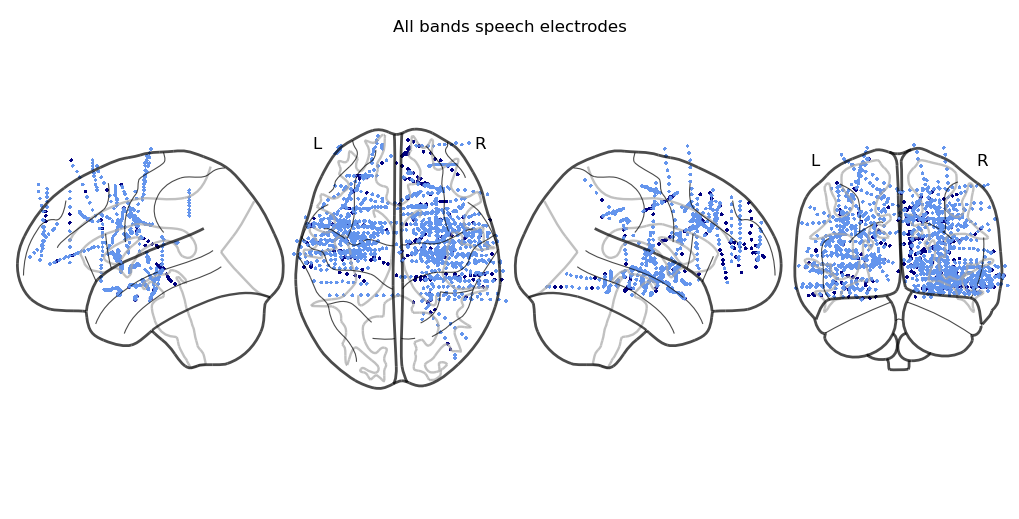

In [6]:
data_vols ={}
chs =[]
mid=90
data = np.zeros((180,180,180))
for sub, ses in sub_ses:

    elec_coords = elec_coord_dic[sub]

    for ch in elec_coords.keys():
        [x, y, z] = elec_coords[ch]
        data[mid+int(x)][mid+int(y)][mid+int(z)] = 1
        data[mid+int(x)+1][mid+int(y)][mid+int(z)] = 0.5
        data[mid+int(x)][mid+int(y)+1][mid+int(z)] = 0.5
        data[mid+int(x)][mid+int(y)][mid+int(z)+1] = 0.5

        data[mid+int(x)-1][mid+int(y)][mid+int(z)] = 0.5
        data[mid+int(x)][mid+int(y)-1][mid+int(z)] = 0.5
        data[mid+int(x)][mid+int(y)][mid+int(z)-1] = 0.5

    for band in bands:
        ch_dic = pickle.load(open('speech_selective_chs_band-%s.pkl'%band,'rb'))
        chs = ch_dic[sub][ses]

        for ch in chs:
            if ch in elec_coords.keys():
                [x, y, z] = elec_coords[ch]
                data[mid+int(x)][mid+int(y)][mid+int(z)] = 20
                data[mid+int(x)+1][mid+int(y)][mid+int(z)] = 19.5
                data[mid+int(x)][mid+int(y)+1][mid+int(z)] = 19.5
                data[mid+int(x)][mid+int(y)][mid+int(z)+1] = 19.5

                data[mid+int(x)-1][mid+int(y)][mid+int(z)] = 19.5
                data[mid+int(x)][mid+int(y)-1][mid+int(z)] = 19.5
                data[mid+int(x)][mid+int(y)][mid+int(z)-1] = 19.5

    data_vols[sub] = data
    
total_vol = np.zeros((180,180,180))
for sub, ses in sub_ses:
    #if sub in ['SD013','SD015']:
    #    continue
    vol = data_vols[sub]
    af = np.array([[1,0,0,-90],
                   [0,1,0,-90],
                   [0,0,1,-90],
                   [0,0,0,1]])
    total_vol = np.maximum(total_vol, vol)
    
colors = ['navy','navy','navy','cornflowerblue','cornflowerblue']
cmap = ListedColormap(colors)
total_vol_img = nib.Nifti1Image(total_vol, af)
fig = plt.figure(1, figsize=(10, 5), frameon=False, dpi=100)
fig.suptitle('All bands speech electrodes', c='black')
display = nilearn.plotting.plot_glass_brain(None, figure=fig, display_mode='lzry')
display.add_contours(total_vol_img, cmap = cmap, filled=True, threshold =0)

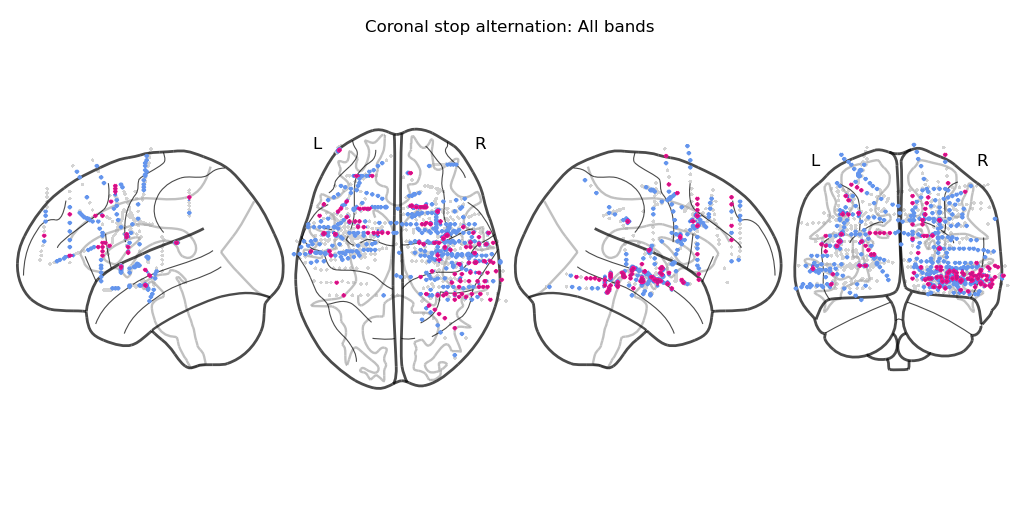

In [7]:
data_vols ={}
dim = 200
fig = plt.figure(1, figsize=(10, 5), frameon=False, dpi=100)
fig.suptitle('Coronal stop alternation: All bands', c='black')
display = nilearn.plotting.plot_glass_brain(None, figure=fig,display_mode='lzry')
total_vol = np.zeros((dim,dim,dim))
for band in bands:
    for sub, ses in sub_ses:
        if sub in ['SD013','SD015']:
            continue
        data = np.zeros((dim,dim,dim))
        elec_coords = elec_coord_dic[sub]

        ch_dic = pickle.load(open('speech_selective_chs_band-%s.pkl'%band,'rb'))

        chs = ch_dic[sub][ses]
        data = set_electrode_values(data, chs, elec_coords, value=1, offset=1)

        special_ch_dic = pickle.load(open('Figure-S9/reviewers-short-baseline_sig_chs_all_bands_tap-t_v3.pkl','rb'))

        chs = special_ch_dic[band]['sig_ology'][sub]
        data = set_electrode_values(data, chs, elec_coords, value=3, offset=2)

        chs = special_ch_dic[band]['sig_etics'][sub]
        data = set_electrode_values(data, chs, elec_coords, value=5, offset=4)

        data_vols[sub] = data

    for sub, ses in sub_ses:
        if sub in ['SD013','SD015']:
            continue
        vol = data_vols[sub]
        af = np.array([[1,0,0,-dim//2],
                       [0,1,0,-dim//2],
                       [0,0,1,-dim//2],
                       [0,0,0,1]])
        total_vol = np.maximum(total_vol, vol)

    colors = ['lightgrey','cornflowerblue','royalblue','deeppink','mediumvioletred']
    cmap = ListedColormap(colors)
    total_vol_img = nib.Nifti1Image(total_vol, af)
display.add_contours(total_vol_img, cmap = cmap, filled=True, threshold =0)
plt.show()

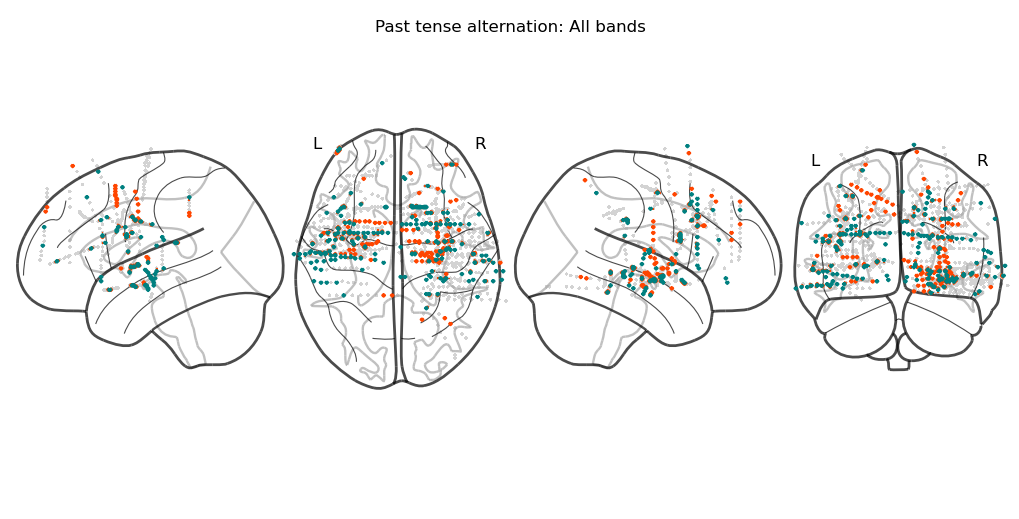

In [8]:
data_vols ={}
dim = 200
fig = plt.figure(1, figsize=(10, 5), frameon=False, dpi=100)
fig.suptitle('Past tense alternation: All bands', c='black')
display = nilearn.plotting.plot_glass_brain(None, figure=fig, display_mode='lzry')
total_vol = np.zeros((dim,dim,dim))
for band in bands:
    for sub, ses in sub_ses:
        if sub in ['SD013','SD015']:
            continue
        data = np.zeros((dim,dim,dim))
        elec_coords = elec_coord_dic[sub]

        ch_dic = pickle.load(open('speech_selective_chs_band-%s.pkl'%band,'rb'))

        chs = ch_dic[sub][ses]
        data = set_electrode_values(data, chs, elec_coords, value=1, offset=1)

        special_ch_dic = pickle.load(open('Figure-S9/reviewers-short-baseline_sig_chs_all_bands_past-d_v3.pkl','rb'))

        chs = special_ch_dic[band]['sig_ology'][sub]
        data = set_electrode_values(data, chs, elec_coords, value=3, offset=2)

        chs = special_ch_dic[band]['sig_etics'][sub]
        data = set_electrode_values(data, chs, elec_coords, value=5, offset=4)

        data_vols[sub] = data

    for sub, ses in sub_ses:
        if sub in ['SD013','SD015']:
            continue
        vol = data_vols[sub]
        af = np.array([[1,0,0,-dim//2],
                       [0,1,0,-dim//2],
                       [0,0,1,-dim//2],
                       [0,0,0,1]])
        total_vol = np.maximum(total_vol, vol)

    colors = ['lightgrey','orangered','orangered','teal','teal']
    cmap = ListedColormap(colors)
    total_vol_img = nib.Nifti1Image(total_vol, af)
display.add_contours(total_vol_img, cmap = cmap, filled=True, threshold =0)
plt.show()

In [ ]:
data_vols ={}
dim = 200
fig = plt.figure(1, figsize=(10, 5), frameon=False, dpi=100)
fig.suptitle('Plural alternation: All bands', c='black')
display = nilearn.plotting.plot_glass_brain(None, figure=fig, display_mode='lzry')
total_vol = np.zeros((dim,dim,dim))
for band in bands:
    for sub, ses in sub_ses:
        if sub in ['SD013','SD015']:
            continue
        data = np.zeros((dim,dim,dim))
        elec_coords = elec_coord_dic[sub]

        ch_dic = pickle.load(open('speech_selective_chs_band-%s.pkl'%band,'rb'))

        chs = ch_dic[sub][ses]
        data = set_electrode_values(data, chs, elec_coords, value=1, offset=1)

        special_ch_dic = pickle.load(open('Figure-S9/reviewers-short-baseline_sig_chs_all_bands_plural-z_v3.pkl','rb'))

        chs = special_ch_dic[band]['sig_ology'][sub]
        data = set_electrode_values(data, chs, elec_coords, value=3, offset=2)

        chs = special_ch_dic[band]['sig_etics'][sub]
        data = set_electrode_values(data, chs, elec_coords, value=5, offset=4)

        data_vols[sub] = data

    for sub, ses in sub_ses:
        if sub in ['SD013','SD015']:
            continue
        vol = data_vols[sub]
        af = np.array([[1,0,0,-dim//2],
                       [0,1,0,-dim//2],
                       [0,0,1,-dim//2],
                       [0,0,0,1]])
        total_vol = np.maximum(total_vol, vol)

    colors = ['lightgrey','darkorange','darkorange','slateblue','slateblue']
    cmap = ListedColormap(colors)
    total_vol_img = nib.Nifti1Image(total_vol, af)
display.add_contours(total_vol_img, cmap = cmap, filled=True, threshold =0)
plt.show()